In [2]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [3]:
# import data
train_c = pd.read_excel("data/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx").set_index("participant_id")
train_f = pd.read_csv("data/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv").set_index("participant_id")
train_q = pd.read_excel("data/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx").set_index("participant_id")
train_solution = pd.read_excel("data/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx").set_index("participant_id")

test_c = pd.read_excel("data/TEST/TEST_CATEGORICAL.xlsx").set_index("participant_id")
test_f = pd.read_csv("data/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv").set_index("participant_id")
test_q = pd.read_excel("data/TEST/TEST_QUANTITATIVE_METADATA.xlsx").set_index("participant_id")

In [4]:
train_solution.head()

,ADHD_Outcome,Sex_F
participant_id,,
UmrK0vMLopoR,1,1
CPaeQkhcjg7d,1,0
Nb4EetVPm3gs,1,0
p4vPhVu91o4b,1,1
M09PXs7arQ5E,1,1


In [5]:
print(train_c.columns)

Index(['Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ'],
      dtype='object')


In [6]:
''' 
Functional connectivity matrix is stored as a flattened functional connectivity matrices, 
commonly used in Pearson correlation matrices. Only the upper triangle (excluding the diagonal) is stored
as the matrix is symmetric. Diagonal = 0.

'''

train_f.head()

,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,0throw_10thcolumn,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
participant_id,,,,,,,,,,,,,,,,,,,,,
70z8Q2xdTXM3,0.222930,0.527903,0.429966,0.060457,0.566489,0.315342,0.508408,-0.078290,0.525692,0.470063,...,0.224985,0.397448,0.422966,0.184642,0.305549,0.420349,0.016328,0.561864,0.471170,0.365221
WHWymJu6zNZi,0.614765,0.577255,0.496127,0.496606,0.404686,0.439724,0.122590,-0.085452,0.120673,0.276350,...,0.217546,-0.014549,0.000440,-0.096451,0.454501,0.343916,0.167313,0.607656,0.550623,0.503176
4PAQp1M6EyAo,-0.116833,0.458408,0.260703,0.639031,0.769337,0.442528,0.637110,0.192010,0.520379,0.378557,...,0.342487,-0.021141,-0.037836,0.075069,0.412712,0.292708,0.391005,0.461544,0.508912,0.624232
obEacy4Of68I,0.199688,0.752714,0.658283,0.575096,0.692867,0.645789,0.522750,0.412188,0.530843,0.259596,...,0.103562,-0.178313,0.210983,-0.018666,0.436313,0.592982,0.216205,0.341272,0.440313,0.558193
s7WzzDcmDOhF,0.227321,0.613268,0.621447,0.562673,0.736709,0.589813,0.266676,0.359668,0.300771,0.331445,...,-0.164956,0.007064,-0.120904,-0.488095,0.493575,-0.215361,0.210685,0.055850,0.119065,0.108273


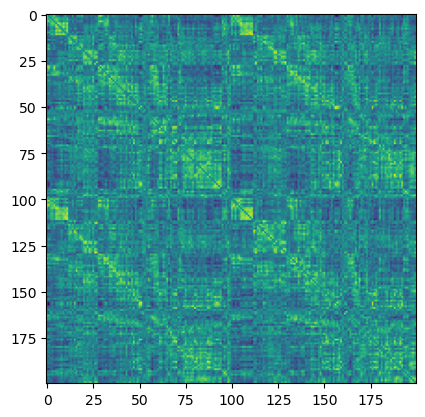

In [7]:
# Change flattened upper triangle into a symmetric matrix
n_regions = 200
n_edges = int(n_regions * (n_regions - 1) / 2)

def upper_to_matrix(upper, n_regions):
    mat = np.zeros((n_regions, n_regions))
    triu_indices = np.triu_indices(n_regions, k=1)
    mat[triu_indices] = upper
    mat += mat.T  # make it symmetric
    return mat

# example for one subject
fc_matrix = upper_to_matrix(train_f.iloc[1], n_regions)
plt.imshow(fc_matrix)
plt.show;

https://pmc.ncbi.nlm.nih.gov/articles/PMC8946919/#sec2dot5-entropy-24-00390

***Characteristic path length.*** Paths are the sequences of distinct nodes that represent the potential flow of information between pairs of brain regions with shorter paths, implying stronger potential for integration. The length of a path estimates the potential for functional integration between brain regions. One of the most commonly used measures of functional integration is the average shortest path length between all pairs of nodes in the network, which is defined as the characteristic path length [15]. Paths between disconnected nodes are defined to have infinite length, which is a problem when calculating this measure, especially in sparse networks such as in functional connectivity. In practice, we take the average only between the existing paths, which can be a problem. For a discussion on this issue please refer to reference [29]. CAN'T AS THE GRAPH IS DISCONNECTED

***Degree distribution.*** A measure of centrality, the degree of an individual node is equal to the number of links connected to that node, i.e., the number of neighbors of the node. The degree distribution is, therefore, the distribution of the degrees of all the nodes in the network. In functional connectivity, nodes with a high degree are interacting functionally with many other nodes in the network [29] and are referred to as hubs.

***Clustering coefficient.*** A measure of segregation, the clustering coefficient is the fraction of the node’s neighbors that are also neighbors of each other, which in graph theory is the fraction of triangles around an individual node. The presence of clusters in functional networks suggests an organization of statistical dependencies indicative of segregated functional neural processing, which is the ability for specialized processing to occur within densely interconnected groups of brain regions. The mean clustering coefficient for the network reflects, on average, the prevalence of clustered connectivity around individual nodes. The mean clustering coefficient is normalized individually for each node and can disproportionately be influenced by nodes with a low degree.

In [8]:
import networkx as nx

def matrix_to_graph(fc_matrix):
    """
    Convert a full FC matrix into a NetworkX graph.
    - binarize: if True, convert nonzero entries to 1.
    - don't apply threshold for now
    """
    mat = np.copy(fc_matrix)
    np.fill_diagonal(mat, 0)  # Remove self-loops.
    G = nx.from_numpy_array(mat)
    return G
    
def get_node_degrees(G):
    # For weighted degree, pass weight='weight'. For unweighted graphs, omit weight.
    return G.degree(weight='weight')

def get_clustering_coefficients(G):
    # Returns a dictionary with local clustering coefficients.
    return nx.clustering(G, weight='weight')

def average_clustering(G):
    # Average clustering coefficient over all nodes.
    return nx.average_clustering(G, weight='weight')

def characteristic_path_length(G_abs, weight='weight'):
    '''
    Calculates the characteristic path length from only connected nodes 
    from the absolute value connectivity matrix.
    '''
    lengths = []
    
    for component in nx.connected_components(G_abs):
        subgraph = G_abs.subgraph(component)
        sp_lengths = dict(nx.all_pairs_dijkstra_path_length(subgraph, weight=weight))
        for u in sp_lengths:
            for v in sp_lengths[u]:
                if u != v:
                    lengths.append(sp_lengths[u][v])

    return np.mean(lengths) if lengths else np.nan

In [9]:
def process_subject(upper, n_regions):
    fc_matrix = upper_to_matrix(upper, n_regions)

    G = matrix_to_graph(fc_matrix)
    G_abs = matrix_to_graph(np.abs(fc_matrix))

    G_degree = get_node_degrees(G)
    G_cluster_coef = get_clustering_coefficients(G)
    G_avg_cluster = average_clustering(G)
    G_abs_charpath_l = characteristic_path_length(G_abs)

    return [G_degree, G_cluster_coef, G_avg_cluster, G_abs_charpath_l]

import time
    
start_time = time.perf_counter()

process_subject(train_f.iloc[1], n_regions)

end_time = time.perf_counter()
print(f"Execution time: {end_time - start_time} seconds")

Execution time: 9.22275845799959 seconds


In [10]:

adhd = train_solution[["ADHD_Outcome"]]
sexf = train_solution[["Sex_F"]]


Optimization terminated successfully.
         Current function value: 0.614568
         Iterations 5


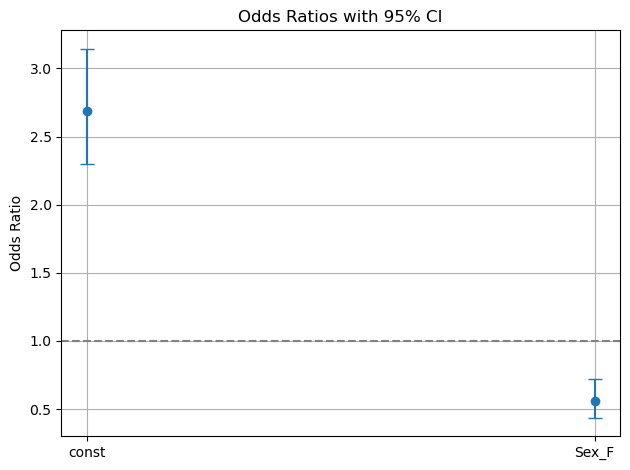

In [11]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# Prepare data
X = sm.add_constant(sexf)  # Add intercept
y = adhd

# Fit model
model = sm.Logit(y, X)
result = model.fit()

# Extract odds ratios and 95% CI
params = result.params
conf = result.conf_int()
odds_ratios = np.exp(params)
conf_odds = np.exp(conf)

# Plot
fig, ax = plt.subplots()
ax.errorbar(odds_ratios.index, odds_ratios.values, 
            yerr=[odds_ratios - conf_odds[0], conf_odds[1] - odds_ratios],
            fmt='o', capsize=5)
ax.axhline(1, color='gray', linestyle='--')
ax.set_ylabel("Odds Ratio")
ax.set_title("Odds Ratios with 95% CI")
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# train_metrics.head()